In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import copy

from matplotlib.patches import Rectangle
from os import path
from skimage import io
from torch import optim
from torch.nn import Linear, CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models

In [2]:
labels_frame = pd.read_csv(path.join('..', 'input', 'inz-data-prep', 'easy_labels_and_data.csv'), index_col=0)

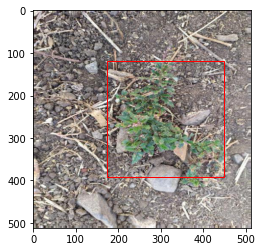

In [3]:
def show_image_bbox(image, bboxes):
    plt.imshow(image)
    ax = plt.gca()
    if isinstance(bboxes, pd.DataFrame):
        for idx, bbox in bboxes.iterrows():
            x = (bbox[0] - bbox[2] / 2) * 512
            y = (bbox[1] - bbox[3] / 2) * 512
            rect = Rectangle((x, y), bbox[2] * 512, bbox[3] * 512, fill=False, edgecolor='r')
            ax.add_patch(rect)
    elif isinstance(bboxes, pd.Series):
        x = (bboxes[0] - bboxes[2] / 2) * 512
        y = (bboxes[1] - bboxes[3] / 2) * 512
        rect = Rectangle((x, y), bboxes[2] * 512, bboxes[3] * 512, fill=False, edgecolor='r')
        ax.add_patch(rect)
    
plt.figure()
show_image_bbox(io.imread(path.join('../input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_1009.jpeg')), 
               labels_frame.iloc[0, 2:6])
plt.show()

## Torch Dataset

In [4]:
class CropWeedDataset(Dataset):
    
    def __init__(self, labels_csv, images_dir, transform=None):
        self.labels_frame = pd.read_csv(labels_csv, index_col=0)
        self.grouped_labels_frame = self.labels_frame.groupby('filename').count()
        self.images_dir = images_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.grouped_labels_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = path.join(self.images_dir,
                                self.grouped_labels_frame.iloc[idx].name)
        image = io.imread(img_name)
        label = int(self.grouped_labels_frame.iloc[idx, 0] > 0)
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
    def get_bbox(self, idx):
        bbox = self.labels_frame.loc[self.labels_frame['filename'] == self.grouped_labels_frame.iloc[idx].name].iloc[:,2:6]
        return bbox
    
    def show_image(self, idx):
        sample = self[idx]
        bbox = self.get_bbox(idx)

        if self.transform:
            numpy_image = sample['image'].numpy().transpose(1, 2, 0)
        else:
            numpy_image = sample['image']

        show_image_bbox(numpy_image, bbox)

    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image) / 255,
                'label': torch.asarray(label)}

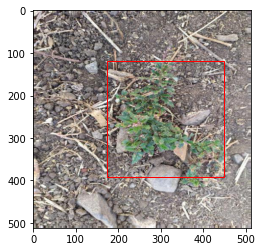

In [9]:
dataset = CropWeedDataset(labels_csv=path.join('..', 'input', 'inz-data-prep', 'easy_labels_and_data.csv'),
                          images_dir=path.join('..','input','crop-and-weed-detection-data-with-bounding-boxes','agri_data', 'data'),
                          transform=ToTensor())

dataset.show_image(0)

## Dataloader

In [29]:
train, test = random_split(dataset, [950, 204], generator=torch.Generator().manual_seed(420))
dataloaders = {'train':DataLoader(train, batch_size=16, shuffle=True, num_workers=2), 
               'val': DataLoader(test, batch_size=16, shuffle=True, num_workers=2)}
dataset_sizes = {'train': 950,
                'val': 204}

## Model training

In [58]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 4, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 4, 5)
        self.fc1 = nn.Linear(4 * 125 * 125, 84)
        self.dropout = nn.Dropout()
        self.fc2 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(self.dropout(F.relu(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(torch.flatten(x, 1)) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model = Net()

In [59]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [40]:
def train_model(model, criterion, optimizer, num_epochs=10):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch in dataloaders[phase]:
                inputs = batch['image'].to(device)
                labels = batch['label'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [60]:
model = train_model(model, criterion, optimizer)

Epoch 0/9
----------
train Loss: 0.0488 Acc: 0.9884
val Loss: 0.0559 Acc: 1.0000

Epoch 1/9
----------
train Loss: 0.0032 Acc: 1.0000
val Loss: 0.0311 Acc: 1.0000

Epoch 2/9
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.0216 Acc: 1.0000

Epoch 3/9
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.0170 Acc: 1.0000

Epoch 4/9
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.0135 Acc: 1.0000

Epoch 5/9
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.0114 Acc: 1.0000

Epoch 6/9
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.0096 Acc: 1.0000

Epoch 7/9
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.0082 Acc: 1.0000

Epoch 8/9
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.0073 Acc: 1.0000

Epoch 9/9
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.0067 Acc: 1.0000

Best val Acc: 1.000000


In [61]:
torch.save(model.state_dict(), 'simple2convnet')